# Loading data

In [1]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
! unzip ml-1m.zip -d .

--2016-10-20 22:07:56--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org... 128.101.34.146
Connecting to files.grouplens.org|128.101.34.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: 'ml-1m.zip'

ml-1m.zip           100%[=====================>]   5.64M  1.17MB/s   in 4.9s   

2016-10-20 22:08:01 (1.15 MB/s) - 'ml-1m.zip' saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ./ml-1m/
  inflating: ./ml-1m/movies.dat      
  inflating: ./ml-1m/ratings.dat     
  inflating: ./ml-1m/README          
  inflating: ./ml-1m/users.dat       


In [11]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ratings = (pd.read_csv('./ml-1m/ratings.dat', engine='python', sep='::', names=['user', 'item', 'rating', 'timestamp'])
    .assign(timestamp=lambda df:pd.to_datetime(df.timestamp * 1000000000))
          )

movies = (pd.read_csv('./ml-1m/movies.dat', engine='python', sep='::', names=['item', 'title', 'genres'])
          .assign(genres=lambda df:df.genres.str.split('|').values)
          .set_index('item', drop=False))

# See http://files.grouplens.org/datasets/movielens/ml-1m-README.txt for more details
users = pd.read_csv('./ml-1m/users.dat', engine='python', sep='::', 
                    names=['user', 'gender', 'age', 'occupation', 'zipcode'])\
    .set_index('user', drop=False)

In [3]:
movies.head()

,item,title,genres
item,,,
1,1,Toy Story (1995),"[Animation, Children's, Comedy]"
2,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
3,3,Grumpier Old Men (1995),"[Comedy, Romance]"
4,4,Waiting to Exhale (1995),"[Comedy, Drama]"
5,5,Father of the Bride Part II (1995),[Comedy]


In [4]:
users.head()

,user,gender,age,occupation,zipcode
user,,,,,
1,1,F,1,10,48067
2,2,M,56,16,70072
3,3,M,25,15,55117
4,4,M,45,7,02460
5,5,M,25,20,55455


In [5]:
print(ratings.shape)
ratings.head()

(1000209, 4)


,user,item,rating,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


## Train/test split

 * Ideally time based split
 * For the sake of simplicity, let's just sample ratings uniformly (breaking the time machine rule)

In [6]:
test = ratings.sample(n=100000, random_state=0)
train_ratings_mask = ~ratings.index.isin(test.index)
train = ratings.loc[train_ratings_mask]

test_user_items = test[['user', 'item']]

print(train.shape)
print(test.shape)

(900209, 4)
(100000, 4)


## Evaluation function and 1st baseline

In [7]:
def rmse(predicted_ratings, ground_truth_ratings=test):

    # predicted rating will be nan if no prediction => returning nan as a result if not all test ratings provided
    joined_ratings = pd.merge(
        ground_truth_ratings,
        predicted_ratings, 
        on=['user', 'item'], how='left', suffixes=['_ground_truth', '_predicted'])

    squared_errors = np.power(joined_ratings.rating_ground_truth - joined_ratings.rating_predicted, 2)
    
    return np.sqrt(np.average(squared_errors))

In [8]:
class AverageTrainingModel:
    
    def __init__(self, average_rating):
        self.average_rating = average_rating

    @classmethod
    def train_model(cls, train_ratings):
        """ Factory method
        """
        average_rating = train_ratings.rating.mean()
        return cls(average_rating)
    
    def predict(self, user_items):
        return user_items.assign(rating=self.average_ratings_array)

    def average_ratings_array(self, user_items):
        return np.repeat(self.average_rating, user_items.shape[0])

In [32]:
def plot_predicted_distribution(predicted_ratings, ground_truth_ratings=test):
    bins = np.linspace(-.5, 7.5, 9)
    plt.hist(predicted_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, label='predicted')
    plt.hist(ground_truth_ratings.rating, 
             bins=bins, normed=True, histtype='step', lw=2, color='grey', label='ground truth')
    plt.ylabel('rating proportion')
    plt.xlabel('rating value')
    plt.xlim([0, 6]); plt.ylim([0, 1.05])
    plt.xticks(range(1, 6))
    plt.legend(loc=2)

1.11416005105


,user,item,rating
324271,1922,2094,3.581826
818637,4918,2808,3.581826
148677,957,1660,3.581826
778790,4653,914,3.581826
525489,3245,3324,3.581826


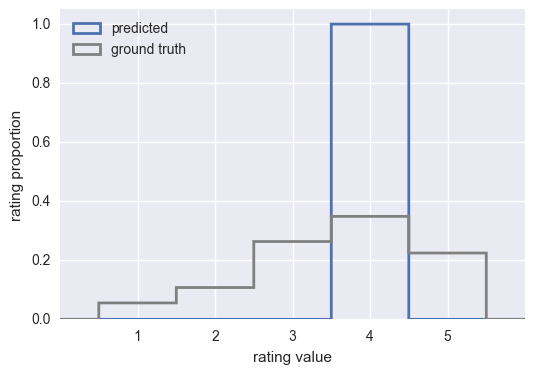

In [33]:
average_model = AverageTrainingModel.train_model(train)
predicted_ratings = average_model.predict(test_user_items)

plot_predicted_distribution(predicted_ratings)
print(rmse(predicted_ratings))
predicted_ratings.head()

## User and item biases as a linear model



In [28]:
from scipy import sparse
from sklearn.linear_model import LinearRegression


def to_coo(row_indexes, col_indexes, values, shape=None, dtype=np.float64):
    return sparse.coo_matrix((values, (row_indexes, col_indexes)), shape=shape, dtype=dtype)

n_samples, _ = train.shape

user_features = to_coo(
    row_indexes=np.arange(n_samples), 
    col_indexes=train.user.values, 
    values=np.repeat(1, n_samples))

user_features

<900209x6041 sparse matrix of type '<class 'numpy.float64'>'
	with 900209 stored elements in COOrdinate format>

In [29]:
def to_indicator_features(user_items):
    n_samples, _ = user_items.shape
    user_features = to_coo(
        row_indexes=np.arange(n_samples), 
        col_indexes=user_items.user.values, 
        values=np.repeat(1, n_samples))

    item_features = to_coo(
        row_indexes=np.arange(n_samples), 
        col_indexes=user_items.item.values, 
        values=np.repeat(1, n_samples))

    return sparse.hstack([user_features, item_features])

indicator_features_matrix = to_indicator_features(user_items=train)
indicator_features_matrix

<900209x9994 sparse matrix of type '<class 'numpy.float64'>'
	with 1800418 stored elements in COOrdinate format>

In [30]:
class UserItemBiasModel:
    
    def __init__(self, fitted_model):
        self.fitted_model = fitted_model

    @classmethod
    def train_model(cls, train):
        """ Factory method
        """
        m = LinearRegression(fit_intercept=True)
        indicator_features_matrix = to_indicator_features(user_items=train)
        m.fit(X=indicator_features_matrix, y=train.rating)
        return cls(m)
    
    def predict(self, user_items, output_column='rating'):
        input_features = to_indicator_features(user_items)
        predicted_ratings = self.fitted_model.predict(X=input_features)
        return user_items.assign(**{output_column: lambda _: predicted_ratings})

0.907260048537


,user,item,rating
324271,1922,2094,2.971389
818637,4918,2808,2.215929
148677,957,1660,3.992876
778790,4653,914,3.771934
525489,3245,3324,2.266152


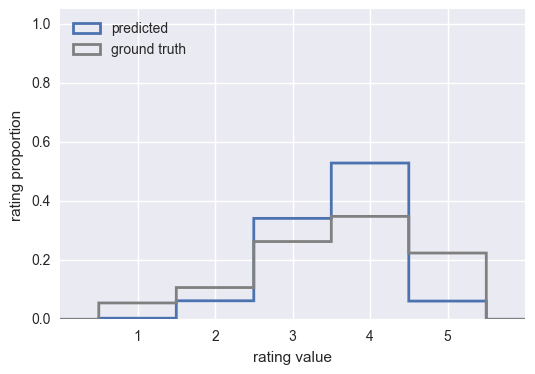

In [31]:
biases_model = UserItemBiasModel.train_model(train)
predicted_ratings = biases_model.predict(test_user_items)

plot_predicted_distribution(predicted_ratings)
print(rmse(predicted_ratings))
predicted_ratings.head()